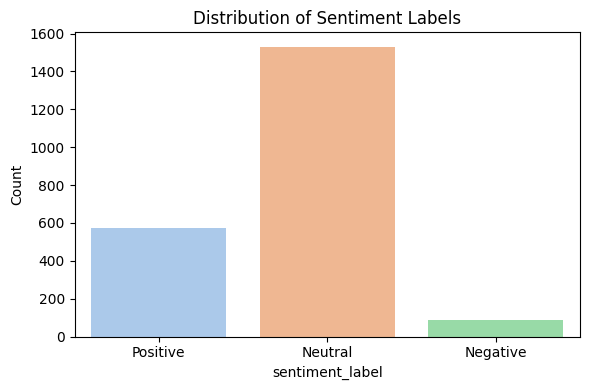

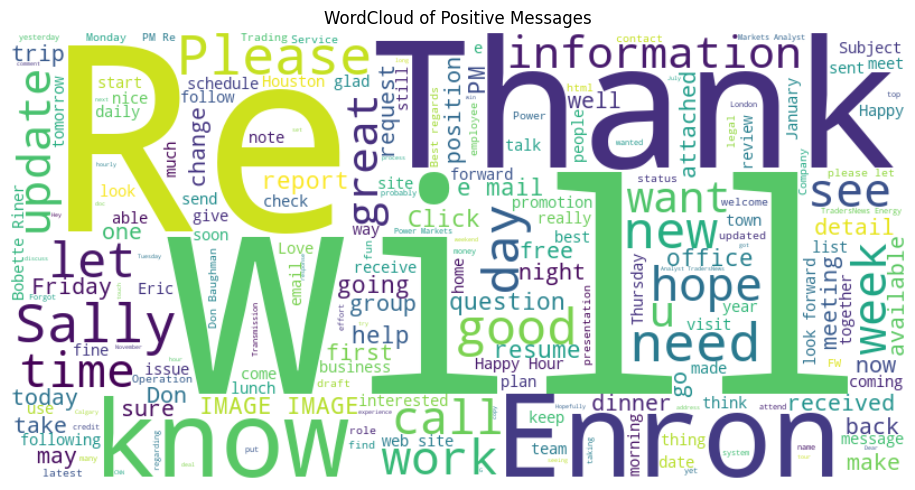

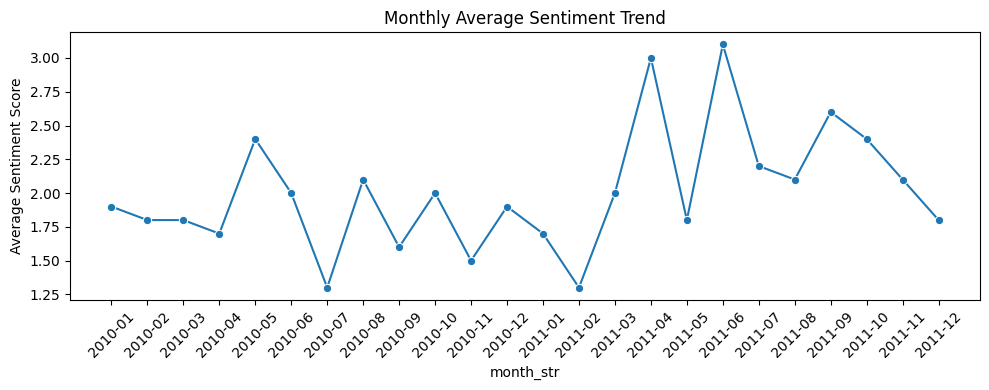

Linear Regression MSE: 0.017456235099730634
Linear Regression R²: -0.018373283597612033


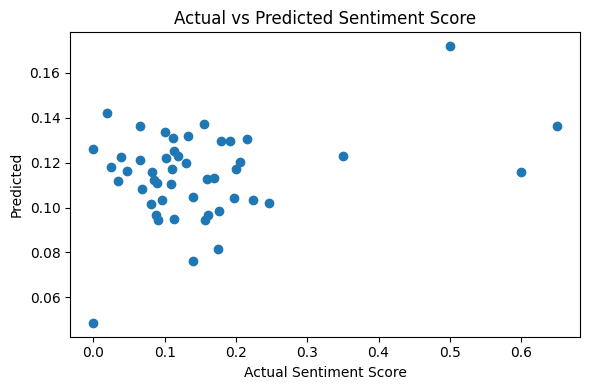

Top 3 Positive Employees (per month):
                          sender    month  score
168     patti.thompson@enron.com  2010-01      4
24        don.baughman@enron.com  2010-01      3
48           eric.bass@enron.com  2010-01      3
73         john.arnold@enron.com  2010-02      6
25        don.baughman@enron.com  2010-02      4
..                           ...      ...    ...
22   bobette.riner@ipgdirect.com  2011-11      4
238         sally.beck@enron.com  2011-11      4
143      kayne.coulter@enron.com  2011-12      4
191     patti.thompson@enron.com  2011-12      3
215      rhonda.denton@enron.com  2011-12      3

[72 rows x 3 columns]

Top 3 Negative Employees (per month):
                          sender    month  score
96       johnny.palmer@enron.com  2010-01      0
192      rhonda.denton@enron.com  2010-01      0
0    bobette.riner@ipgdirect.com  2010-01      1
217         sally.beck@enron.com  2010-02     -2
121      kayne.coulter@enron.com  2010-02      1
..                

In [15]:
# ===============================
# 📌 Employee Sentiment Analysis Project
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 📂 1. Load and Clean Dataset
# ===============================
df = pd.read_csv("test(in).csv", encoding='latin1')

# Standardize column names
df.columns = df.columns.str.strip().str.lower()
df.rename(columns={"from": "sender"}, inplace=True)

# Combine subject + body
df['message'] = df['subject'].fillna('') + " " + df['body'].fillna('')

# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# ===============================
# 💬 2. Sentiment Labeling
# ===============================
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['message'].apply(get_sentiment_score)

# Custom thresholding based on FAQs (avoid arbitrary range)
def label_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)

# ===============================
# 📊 3. EDA and Visualizations
# ===============================

# 3.1 Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_label', data=df, palette='pastel')
plt.title("Distribution of Sentiment Labels")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visualizations/sentiment_distribution.png")
plt.show()

# 3.2 WordCloud for Positive Messages
positive_text = " ".join(df[df['sentiment_label']=="Positive"]['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Positive Messages")
plt.tight_layout()
plt.savefig("visualizations/positive_wordcloud.png")
plt.show()

# ===============================
# 📈 4. Monthly Sentiment Scoring
# ===============================
df['month'] = df['date'].dt.to_period('M')
df['score'] = df['sentiment_label'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

monthly_score = df.groupby(['sender', 'month'])['score'].sum().reset_index()
monthly_avg = monthly_score.groupby('month')['score'].mean().reset_index()

# Trend plot
plt.figure(figsize=(10,4))
monthly_avg['month_str'] = monthly_avg['month'].astype(str)
sns.lineplot(data=monthly_avg, x='month_str', y='score', marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Average Sentiment Trend")
plt.ylabel("Average Sentiment Score")
plt.tight_layout()
plt.savefig("visualizations/monthly_sentiment_trend.png")
plt.show()

# ===============================
# 🧑‍💼 5. Employee Ranking
# ===============================
top_scores = monthly_score.copy()
top_scores['month'] = top_scores['month'].astype(str)

top_positive = top_scores.sort_values(['month','score', 'sender'], ascending=[True, False, True]).groupby('month').head(3)
top_negative = top_scores.sort_values(['month','score', 'sender'], ascending=[True, True, True]).groupby('month').head(3)

# ===============================
# ⚠️ 6. Flight Risk Detection
# ===============================
df['is_negative'] = df['sentiment_label'] == 'Negative'

risk_df = df[['sender', 'date', 'is_negative']].copy()
risk_df = risk_df.sort_values(['sender', 'date'])

# Rolling 30-day window negative counts
# Calculate rolling 30-day negative message counts per sender
risk_df = risk_df.sort_values(['sender', 'date'])
risk_df['neg_count_30days'] = (
    risk_df
    .set_index('date')
    .groupby('sender')['is_negative']
    .rolling('30D').sum()
    .reset_index(level=0, drop=True)
    .values
)

# Flag flight risk
risk_df['flight_risk'] = risk_df['neg_count_30days'] >= 4
flight_risk_employees = risk_df[risk_df['flight_risk']]['sender'].unique()

# ===============================
# 📉 7. Predictive Modeling
# ===============================
df['message_length'] = df['message'].str.len()
df['word_count'] = df['message'].str.split().apply(len)
df['month_str'] = df['month'].astype(str)

model_df = df.groupby(['month_str', 'sender']).agg({
    'sentiment_score': 'mean',
    'message_length': 'mean',
    'word_count': 'mean'
}).reset_index()

X = model_df[['message_length', 'word_count']]
y = model_df['sentiment_score']

# Train-test split
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression MSE:", mse)
print("Linear Regression R²:", r2)

# Plot predictions
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Sentiment Score")
plt.tight_layout()
plt.savefig("visualizations/model_performance.png")
plt.show()

# ===============================
# ✅ Summary Output
# ===============================
print("Top 3 Positive Employees (per month):")
print(top_positive)

print("\nTop 3 Negative Employees (per month):")
print(top_negative)

print("\nFlight Risk Employees:")
print(flight_risk_employees)
